# Example: CitiBike data

Adapted from Kelsey Jordahl
https://gist.github.com/kjordahl/5957573

In [1]:
import requests  
import json
from pyproj import Proj
from shapely.geometry import Point
import geopandas as gp

NYC borough boundaries downloaded from [Bytes of the Big Apple](http://www.nyc.gov/html/dcp/download/bytes/nybb_13a.zip)

In [3]:
boros = gp.GeoDataFrame.from_file('nybb_15b/nybb.shp')
boros

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,3,Brooklyn,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...
2,4,Queens,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...
3,1,Manhattan,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...


Load real time bike station data from [CitiBike](http://citibikenyc.com) json API:

In [4]:
# get the bike data and convert it to a ditcionary
endpoint_url = 'http://citibikenyc.com/stations/json'
response = requests.get(endpoint_url)
data = json.loads(response.text)
data

{'executionTime': '2018-02-26 12:41:15 AM',
 'stationBeanList': [{'altitude': '',
   'availableBikes': 1,
   'availableDocks': 38,
   'city': '',
   'id': 72,
   'landMark': '',
   'lastCommunicationTime': '2018-02-26 12:37:38 AM',
   'latitude': 40.76727216,
   'location': '',
   'longitude': -73.99392888,
   'postalCode': '',
   'stAddress1': 'W 52 St & 11 Ave',
   'stAddress2': '',
   'stationName': 'W 52 St & 11 Ave',
   'statusKey': 1,
   'statusValue': 'In Service',
   'testStation': False,
   'totalDocks': 39},
  {'altitude': '',
   'availableBikes': 20,
   'availableDocks': 13,
   'city': '',
   'id': 79,
   'landMark': '',
   'lastCommunicationTime': '2018-02-26 12:37:39 AM',
   'latitude': 40.71911552,
   'location': '',
   'longitude': -74.00666661,
   'postalCode': '',
   'stAddress1': 'Franklin St & W Broadway',
   'stAddress2': '',
   'stationName': 'Franklin St & W Broadway',
   'statusKey': 1,
   'statusValue': 'In Service',
   'testStation': False,
   'totalDocks': 33}

In [5]:
# convert the relevant part to a geodataframe
df = gp.GeoDataFrame(data['stationBeanList'])
df.head()

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks
0,,1,38,,72,,2018-02-26 12:37:38 AM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,39
1,,20,13,,79,,2018-02-26 12:37:39 AM,40.719116,,-74.006667,,Franklin St & W Broadway,,Franklin St & W Broadway,1,In Service,False,33
2,,24,3,,82,,2018-02-26 12:37:36 AM,40.711174,,-74.000165,,St James Pl & Pearl St,,St James Pl & Pearl St,1,In Service,False,27
3,,35,25,,83,,2018-02-26 12:39:11 AM,40.683826,,-73.976323,,Atlantic Ave & Fort Greene Pl,,Atlantic Ave & Fort Greene Pl,1,In Service,False,62
4,,14,5,,119,,2018-02-26 12:39:33 AM,40.696089,,-73.978034,,Park Ave & St Edwards St,,Park Ave & St Edwards St,1,In Service,False,19


In [6]:
# there is one row for each bike station.  How many stations are there? 
len(df)

813

In [7]:
# in the file above, there are lon-lats, but no geometry field
# we need to set that up

s = gp.GeoSeries([Point(x, y) for x, y in zip(df['longitude'], df['latitude'])])
df['geometry'] = s
df.crs = {'init': 'epsg:4326', 'no_defs': True}
df.geometry.total_bounds

array([-74.0969366 ,  40.65539977, -73.9077436 ,  40.81439444])

In [8]:
# make sure they are on the same CRS.  
# checking the bounds is a nice way of seeing this
df.to_crs(boros.crs, inplace=True)
df.geometry.total_bounds

array([  957370.14732176,   178056.37414829,  1009803.53178432,
         235986.42166716])

In [9]:
boros

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,3,Brooklyn,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...
2,4,Queens,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...
3,1,Manhattan,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...


In [10]:
# the geometry objects can do lots of cool stuff.  For example: 

manhattan = boros.geometry[3]
in_mn = df.geometry.within(manhattan)
print(sum(in_mn), 'stations in Manhattan')

414 stations in Manhattan


# Your turn

You can read about the range of operations available in geopandas here: 
    
http://geopandas.org/index.html

Your assignment is to: 

1. Calculate how many stations are in each borough
2. Calculate how many bikes are currently available in each borough
3. Read about and try at least two new spatial or geometric operations (beyond what I've covered here). 

In [11]:
manhattan = boros.geometry[3]
in_mn = df.geometry.within(manhattan)
print(sum(in_mn), 'stations in Manhattan')

414 stations in Manhattan


In [12]:
bronx = boros.geometry[4]
in_mn = df.geometry.within(bronx)
print(sum(in_mn), 'stations in bronx')

0 stations in bronx


In [13]:
queens = boros.geometry[2]
in_mn = df.geometry.within(queens)
print(sum(in_mn), 'stations in queens')

81 stations in queens


In [14]:
brooklyn = boros.geometry[1]
in_mn = df.geometry.within(brooklyn)
print(sum(in_mn), 'stations in brooklyn')

266 stations in brooklyn


In [15]:
staten_island = boros.geometry[0]
in_mn = df.geometry.within(staten_island)
print(sum(in_mn), 'stations in staten island')

0 stations in staten island


In [16]:
staten_island = boros.geometry[0]
in_mn = df.geometry.within(staten_island)
print(sum(df['availableBikes'][in_mn]))

0


In [17]:
brooklyn = boros.geometry[1]
in_mn = df.geometry.within(brooklyn)
print(sum(df['availableBikes'][in_mn]))

2609


In [18]:
queens = boros.geometry[2]
in_mn = df.geometry.within(queens)
print(sum(df['availableBikes'][in_mn]))

373


In [19]:
manhattan = boros.geometry[3]
in_mn = df.geometry.within(manhattan)
print(sum(df['availableBikes'][in_mn]))

4932


In [20]:
bronx = boros.geometry[4]
in_mn = df.geometry.within(bronx)
print(sum(df['availableBikes'][in_mn]))

0


In [30]:
#spatial operation: example 1
#Spatial Joins
#In a Spatial Join, two geometry objects are merged based on their spatial relationship to one another
# One GeoDataFrame of NYC bounduries, one of citibike.
# Want to merge so we can get each availablebikes in the station.

boros.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
index_right,,,,,
0,5,Staten Island,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,3,Brooklyn,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...
2,4,Queens,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...
3,1,Manhattan,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...


In [31]:
df.head()

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks,geometry
index_left,,,,,,,,,,,,,,,,,,,
0,,1,38,,72,,2018-02-26 12:37:38 AM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,39,POINT (985931.706502895 218814.7571059909)
1,,20,13,,79,,2018-02-26 12:37:39 AM,40.719116,,-74.006667,,Franklin St & W Broadway,,Franklin St & W Broadway,1,In Service,False,33,POINT (982402.0068864136 201269.770346975)
2,,24,3,,82,,2018-02-26 12:37:36 AM,40.711174,,-74.000165,,St James Pl & Pearl St,,St James Pl & Pearl St,1,In Service,False,27,POINT (984204.131576321 198376.4207269395)
3,,35,25,,83,,2018-02-26 12:39:11 AM,40.683826,,-73.976323,,Atlantic Ave & Fort Greene Pl,,Atlantic Ave & Fort Greene Pl,1,In Service,False,62,POINT (990816.693171227 188413.5778061197)
4,,14,5,,119,,2018-02-26 12:39:33 AM,40.696089,,-73.978034,,Park Ave & St Edwards St,,Park Ave & St Edwards St,1,In Service,False,19,POINT (990341.0662772973 192881.3587593974)


In [32]:
common = gp.sjoin(df, boros, how="inner", op='intersects')
common


,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,...,statusKey,statusValue,testStation,totalDocks,geometry,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
0,,1,38,,72,,2018-02-26 12:37:38 AM,40.767272,,-73.993929,...,1,In Service,False,39,POINT (985931.706502895 218814.7571059909),3,1,Manhattan,358408.460709,6.364467e+08
1,,20,13,,79,,2018-02-26 12:37:39 AM,40.719116,,-74.006667,...,1,In Service,False,33,POINT (982402.0068864136 201269.770346975),3,1,Manhattan,358408.460709,6.364467e+08
2,,24,3,,82,,2018-02-26 12:37:36 AM,40.711174,,-74.000165,...,1,In Service,False,27,POINT (984204.131576321 198376.4207269395),3,1,Manhattan,358408.460709,6.364467e+08
6,,23,8,,127,,2018-02-26 12:37:42 AM,40.731724,,-74.006744,...,1,In Service,False,31,POINT (982380.8081703536 205863.5336667247),3,1,Manhattan,358408.460709,6.364467e+08
7,,28,1,,128,,2018-02-26 12:38:05 AM,40.727103,,-74.002971,...,1,In Service,False,30,POINT (983426.5668231644 204179.6463416795),3,1,Manhattan,358408.460709,6.364467e+08
10,,19,19,,146,,2018-02-26 12:40:55 AM,40.716250,,-74.009106,...,1,In Service,False,39,POINT (981725.7239503184 200225.863801748),3,1,Manhattan,358408.460709,6.364467e+08
11,,21,10,,150,,2018-02-26 12:40:49 AM,40.720874,,-73.980858,...,1,In Service,False,31,POINT (989556.0615834089 201910.8022852982),3,1,Manhattan,358408.460709,6.364467e+08
12,,8,24,,151,,2018-02-26 12:40:20 AM,40.722104,,-73.997249,...,1,In Service,False,33,POINT (985012.5446468905 202358.4293712162),3,1,Manhattan,358408.460709,6.364467e+08
13,,12,17,,152,,2018-02-26 12:38:13 AM,40.714740,,-74.009106,...,1,In Service,False,29,POINT (981725.5641854072 199675.6701459276),3,1,Manhattan,358408.460709,6.364467e+08
15,,13,22,,161,,2018-02-26 12:40:10 AM,40.729170,,-73.998102,...,1,In Service,False,35,POINT (984775.9628196507 204932.9545571026),3,1,Manhattan,358408.460709,6.364467e+08


In [33]:
len(common)

761

In [59]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from shapely.geometry import Point
import pandas as pd

In [60]:
#spatial operation: example 2
# when working with spatial data, we need a special tool that can also aggregate geometric features. 
#In the geopandas library, that functionality is provided by the dissolve function.
#If we are interested in aggregate populations, however, we can pass different functions to the dissolve method to aggregate populations:
boros = gp.read_file('nybb_15b/nybb.shp')
boros

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,3,Brooklyn,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...
2,4,Queens,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...
3,1,Manhattan,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...


In [61]:
# set the index to be the name of the borough, and sort in order of the borough code
boros.reset_index(inplace=True)
boros.set_index('BoroName', inplace=True)
boros.sort_values(by='BoroCode', inplace=True)
boros


,index,BoroCode,Shape_Leng,Shape_Area,geometry
BoroName,,,,,
Manhattan,3,1,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...
Bronx,4,2,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...
Brooklyn,1,3,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...
Queens,2,4,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...
Staten Island,0,5,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...


In [62]:
population = pd.Series({'Manhattan': 1585873, 'Bronx': 1385108, 'Brooklyn': 2504700,
                     'Queens': 2230722, 'Staten Island': 468730})
population

Bronx            1385108
Brooklyn         2504700
Manhattan        1585873
Queens           2230722
Staten Island     468730
dtype: int64

In [63]:
boros['population'] = population
boros

,index,BoroCode,Shape_Leng,Shape_Area,geometry,population
BoroName,,,,,,
Manhattan,3,1,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...,1585873
Bronx,4,2,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...,1385108
Brooklyn,1,3,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...,2504700
Queens,2,4,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...,2230722
Staten Island,0,5,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...,468730


In [64]:
boros.head()

,index,BoroCode,Shape_Leng,Shape_Area,geometry,population
BoroName,,,,,,
Manhattan,3,1,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...,1585873
Bronx,4,2,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...,1385108
Brooklyn,1,3,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...,2504700
Queens,2,4,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...,2230722
Staten Island,0,5,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...,468730


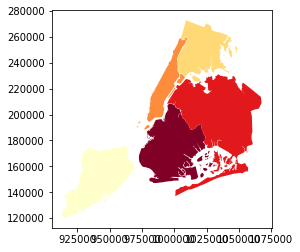

In [65]:
boros1 = boros[['BoroCode', 'geometry', 'population']]

agg = boros1.dissolve(by='BoroCode', aggfunc='sum')

base = agg.plot(column = 'population', scheme='quantiles', cmap='YlOrRd');

base
